The reason we are focusing on PM 2.5 in Fresno County: Fresno County  ranks very high for PM2.5 pollution in the San Joaquin Valley. In fact, Fresno consistently lands in the top 5 most polluted counties in the U.S. for both short-term and year-round PM2.5 levels, according to the American Lung Association’s 2024 State of the Air report.

In [ ]:
# Decodes of CA and San Joaquin Valley Counties
ca_code = "06"
fresno_code = "019"
kern_code = "029"
kings_code = "031"
madera_code = "039"
merced_code = "047"
san_joaquin_code = "077"
stanislaus_code = "099"
tulare_code = "107"

In [ ]:
# Decodes of Pollutants
pm25 = "88101"
pm10 = "81102"
ozone = "44201"
no2 = "42602"
co = "42101"
so2 = "42401"

wind_speed = "61101"
wind_direction = "61102"
temperature = "62101"
rel_humidity = "62201"


In [ ]:
# import the libraries
import requests
import pandas as pd
import time

# show all columns of dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)           # No line wrapping
pd.set_option('display.max_colwidth', None)


Step 1: Collect all the Pollutant Data In a Single DataFrame

In [ ]:
# Initialize an empty DataFrame
fresno_df = pd.DataFrame()

# Loop over the years from 1980 to 2024
for year in range(1999, 2025):
    url = f"https://aqs.epa.gov/data/api/dailyData/byCounty?email=munkh-erdene.khuderbaatar@sjsu.edu&key=bluebird66&param={pm10},{pm25},{ozone},{no2},{co},{so2}&bdate={str(year) + '0101'}&edate={str(year) + '1231'}&state={ca_code}&county={fresno_code}"

    try:
        # Make the request
        response = requests.get(url)
        data = response.json()
        if data.get('Header', [])[0]['status'] == "Success":
            # Normalize the JSON data into a flat DataFrame
            current_year_data = pd.json_normalize(data.get('Data', []))

            # Concatenate the current year's data with the main DataFrame
            fresno_df = pd.concat([fresno_df, current_year_data], ignore_index=True)
            print(f"Added data for {year}")
        else:
            print(f"No data for {year}")

    except requests.exceptions.RequestException as e:
        # Handle any request-related errors (e.g., network issues)
        print(f"Request failed for {year}: {e}")

    # Wait for a short time before the next request (6 second)
    time.sleep(3)

# After the loop ends, you can process the `df` DataFrame
print("complete")
fresno_df.to_csv('fresno_df.csv', index=False)


Added data for 1999
Added data for 2000
Added data for 2001
Added data for 2002
Added data for 2003
Added data for 2004
Added data for 2005
Added data for 2006
Added data for 2007
Added data for 2008
Added data for 2009
Added data for 2010
Added data for 2011
Added data for 2012
Added data for 2013
Added data for 2014
Added data for 2015
Added data for 2016
Added data for 2017
Added data for 2018
Added data for 2019
Added data for 2020
Added data for 2021
Added data for 2022
Added data for 2023
Added data for 2024
complete


Step 2: Segregate the data to Respective Pollutant Dataframes

In [ ]:
fresno_pm25 = fresno_df[fresno_df["parameter_code"] == f"{pm25}"].groupby(['date_local', 'site_number'])['aqi'].mean().reset_index()

In [ ]:
fresno_pm25

,date_local,site_number,aqi
0,1999-01-03,0008,119.0
1,1999-01-03,5001,98.0
2,1999-01-06,0008,115.0
3,1999-01-06,5001,91.0
4,1999-01-09,0008,159.0
...,...,...,...
29319,2024-12-31,0500,18.0
29320,2024-12-31,2009,3.0
29321,2024-12-31,2016,85.0
29322,2024-12-31,5001,62.0


In [ ]:
fresno_pm10 = fresno_df[(fresno_df["parameter_code"] == f"{pm10}")].groupby(["date_local", "site_number"])["aqi"].mean().reset_index()

In [ ]:
# We should select the 8-HR RUN AVG sample duration as the 1 Hour is NaN
fresno_ozone = fresno_df[(fresno_df["parameter_code"] == f"{ozone}") & (fresno_df["sample_duration"] == "8-HR RUN AVG BEGIN HOUR")].groupby(["date_local", "site_number"])["aqi"].mean().reset_index()

In [ ]:
fresno_no2 = fresno_df[(fresno_df["parameter_code"] == f"{no2}")].groupby(["date_local", "site_number"])["aqi"].mean().reset_index()

In [ ]:
# We should select the 8-HR RUN AVG sample duration as the 1 Hour is NaN
fresno_co = fresno_df[(fresno_df["parameter_code"] == f"{co}") & (fresno_df["sample_duration"] == "8-HR RUN AVG END HOUR")].groupby(["date_local", "site_number"])["aqi"].mean().reset_index()

In [ ]:
fresno_so2 = fresno_df[(fresno_df["parameter_code"] == f"{so2}") & (fresno_df["sample_duration_code"] == "1")].groupby(["date_local", "site_number"])["aqi"].mean().reset_index()

Step 3: Check Correlation and Significant Relationships Between PM 2.5 and Other Pollutants

Step 3.1: Apply Cross-Correlation Function (CCF) to Check for Linear Relationship of PM 2.5 and PM 10; CCF measures the linear relationship between two time series at each lag, and this is typically done using the Pearson correlation coefficient.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# merge the pm25 and pm10 data
fresno_pm25_pm10 = pd.merge(fresno_pm25, fresno_pm10, on=["date_local", "site_number"], how="left", suffixes=("_pm25", "_pm10"))

In [ ]:
# find the longest consecutive sequence of rows
df_sorted = fresno_pm25_pm10.sort_values(by=['site_number', 'date_local']).reset_index(drop=True)

df_sorted['valid'] = df_sorted[['aqi_pm25', 'aqi_pm10']].notna().all(axis=1)

df_sorted['group'] = (
    (df_sorted['site_number'] != df_sorted['site_number'].shift()) |
    (df_sorted['valid'] != df_sorted['valid'].shift())
).cumsum()

valid_groups = df_sorted[df_sorted['valid']].groupby(['site_number', 'group'])

group_sizes = valid_groups.size()

max_site, max_group = group_sizes.idxmax()   # returns (site_number, group)
max_length = group_sizes.max()

# extract the actual rows
longest_run_df = df_sorted[
    (df_sorted['site_number'] == max_site) &
    (df_sorted['group'] == max_group)
]

In [ ]:
longest_run_df

,date_local,site_number,aqi_pm25,aqi_pm10,valid,group
6154,2017-01-31,0011,111.750000,50.0,True,1595
6155,2017-02-01,0011,97.666667,44.5,True,1595
6156,2017-02-02,0011,61.333333,21.5,True,1595
6157,2017-02-03,0011,38.666667,10.0,True,1595
6158,2017-02-04,0011,57.000000,19.0,True,1595
...,...,...,...,...,...,...
7620,2021-02-05,0011,85.000000,38.0,True,1595
7621,2021-02-06,0011,97.000000,43.0,True,1595
7622,2021-02-07,0011,113.000000,47.0,True,1595
7623,2021-02-08,0011,96.000000,42.0,True,1595


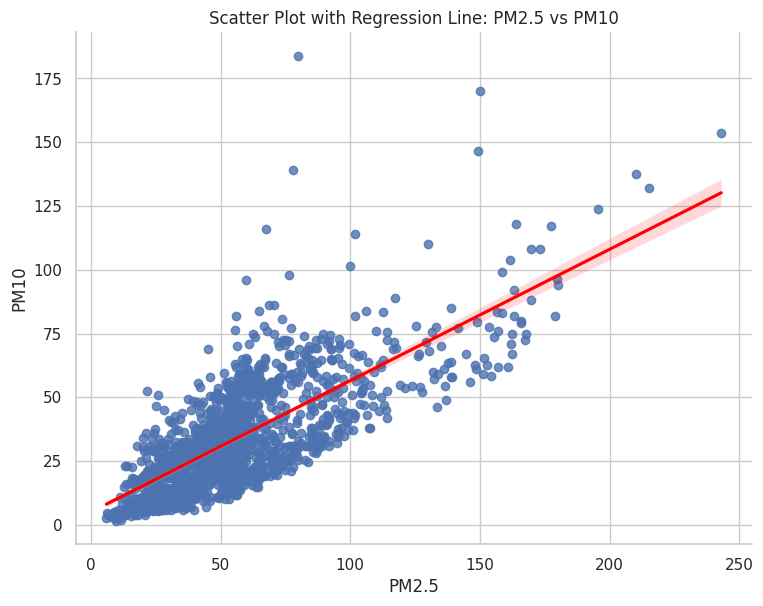

In [ ]:
# Assuming longest_run_df is your DataFrame
sns.set(style="whitegrid")

# lmplot works on dataframes using string column names
sns.lmplot(
    x="aqi_pm25",
    y="aqi_pm10",
    data=longest_run_df,
    height=6,
    aspect=1.3,
    line_kws={'color': 'red'}
)

plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Scatter Plot with Regression Line: PM2.5 vs PM10')
plt.show()

In [ ]:
import matplotlib.dates as mdates


<ipython-input-32-9a578a7c80a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


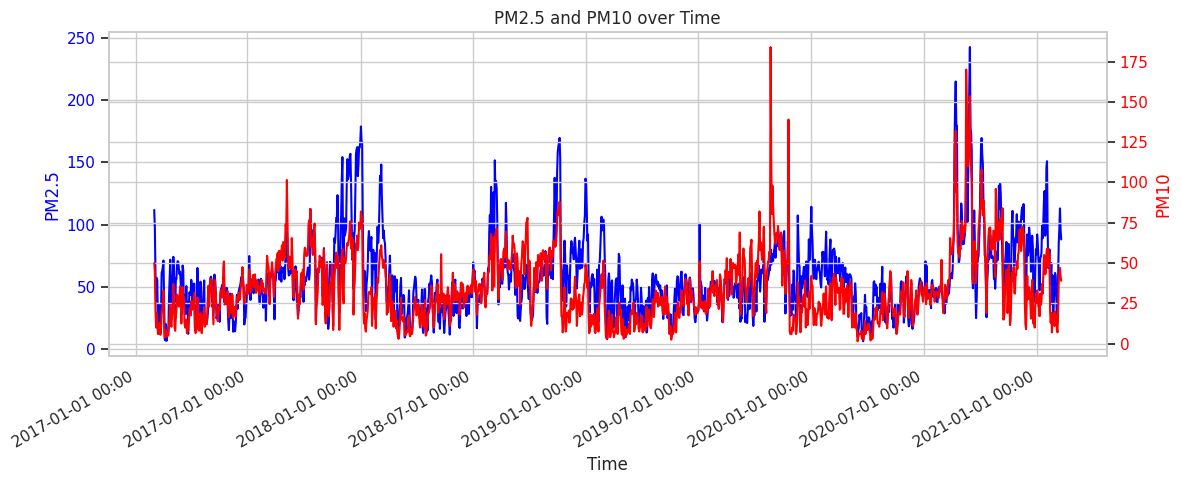

In [ ]:
# Convert date_local to datetime if it isn't already
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot PM2.5 on ax1
ax1.plot(longest_run_df["date_local"], longest_run_df["aqi_pm25"], color='blue', label='PM2.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # Auto-rotate and align date labels

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(longest_run_df["date_local"], longest_run_df["aqi_pm10"], color='red', label='PM10')
ax2.set_ylabel('PM10', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('PM2.5 and PM10 over Time')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# apply CCF
from statsmodels.tsa.stattools import ccf

In [ ]:
# get the individual series
pm25_series = longest_run_df["aqi_pm25"]
pm10_series = longest_run_df["aqi_pm10"]

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, pm10_series)



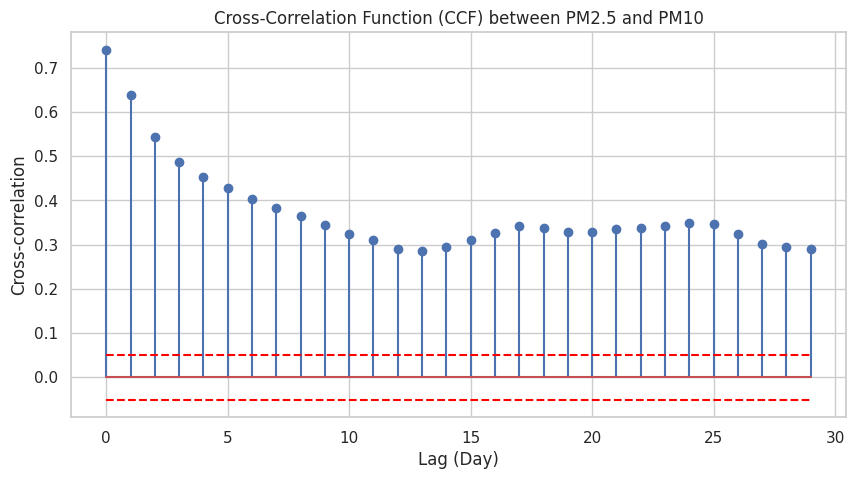

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, pm10_series)

N = len(pm25_series)  # Number of observations
conf_bound = 1.96 / np.sqrt(N)

# Plot the CCF
lags = np.arange(30)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values[:30])
plt.hlines([conf_bound, -conf_bound], xmin=0, xmax=max(lags), linestyles='dashed', colors='red')
plt.title('Cross-Correlation Function (CCF) between PM2.5 and PM10')
plt.xlabel('Lag (Day)')
plt.ylabel('Cross-correlation')
plt.show()

Interpretation: PM2.5 and PM10 levels are strongly and directly linked. As these are both particulate matters, this was expected. Monitoring one of them could give a good estimate of the other in real time.
The cross-correlation does not drop off rapidly after 0, meaning that there is a moderate correlation of past PM 2.5 and future PM 10. When PM2.5 is high now, PM10 tends to stay somewhat high for a while (1-2 days) afterward, or vice versa. The red dashed lines represent the 95% confidence bounds (+- 1.96 / N^1/2). Any stem going beyond these lines is statistically significant at that lag, meaning the correlation did not occur by random chance.

Test for LSTM Improvement With PM 10

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])
df = longest_run_df.sort_values('date_local')

# Select relevant columns
data_pm25 = df[['aqi_pm25']].values
data_pm25_pm10 = df[['aqi_pm25', 'aqi_pm10']].values

<ipython-input-40-933901ae5455>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


In [ ]:
# Scale
scaler_1 = MinMaxScaler()
data_pm25_scaled = scaler_1.fit_transform(data_pm25)

scaler_2 = MinMaxScaler()
data_pm25_pm10_scaled = scaler_2.fit_transform(data_pm25_pm10)

In [ ]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # PM2.5 as target
    return np.array(X), np.array(y)

# 7-day sequence length
seq_len = 7

# For PM2.5 only
X_pm25, y_pm25 = create_sequences(data_pm25_scaled, seq_len)

# For PM2.5 + PM10
X_pm25_pm10, y_pm25_pm10 = create_sequences(data_pm25_pm10_scaled, seq_len)

In [ ]:
train_size = int(0.8 * len(X_pm25))

# PM2.5 only
X_train_1, X_test_1 = X_pm25[:train_size], X_pm25[train_size:]
y_train_1, y_test_1 = y_pm25[:train_size], y_pm25[train_size:]

# PM2.5 + PM10
X_train_2, X_test_2 = X_pm25_pm10[:train_size], X_pm25_pm10[train_size:]
y_train_2, y_test_2 = y_pm25_pm10[:train_size], y_pm25_pm10[train_size:]

Model 1: PM2.5 only



In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape=(seq_len, 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

model1.fit(X_train_1, y_train_1, epochs=8, batch_size=8, validation_data=(X_test_1, y_test_1))

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0192 - val_loss: 0.0155
Epoch 2/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0140
Epoch 3/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 0.0129
Epoch 4/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 5/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0102
Epoch 6/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0090
Epoch 7/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0083
Epoch 8/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0077


Model 2: PM2.5 and PM10


In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape=(seq_len, 2)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

model2.fit(X_train_2, y_train_2, epochs=8, batch_size=8, validation_data=(X_test_2, y_test_2))

Epoch 1/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0181 - val_loss: 0.0157
Epoch 2/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0126
Epoch 3/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.0124
Epoch 4/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0102
Epoch 5/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0058 - val_loss: 0.0095
Epoch 6/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 7/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049 - val_loss: 0.0085
Epoch 8/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0079


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions
pred1 = model1.predict(X_test_1)
pred2 = model2.predict(X_test_2)

# Inverse transform
y_test_1_inv = scaler_1.inverse_transform(y_test_1.reshape(-1, 1))
pred1_inv = scaler_1.inverse_transform(pred1)

y_test_2_inv = scaler_2.inverse_transform(np.hstack((y_test_2.reshape(-1,1), np.zeros((len(y_test_2), 1)))))[:,0]
pred2_inv = scaler_2.inverse_transform(np.hstack((pred2, np.zeros((len(pred2), 1)))))[:,0]

# Calculate MAE
mae1 = mean_absolute_error(y_test_1_inv, pred1_inv)
mae2 = mean_absolute_error(y_test_2_inv, pred2_inv)

print(f"MAE (PM2.5 only): {mae1}")
print(f"MAE (PM2.5 + PM10): {mae2}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
MAE (PM2.5 only): 15.126907671949022
MAE (PM2.5 + PM10): 15.191465431292446


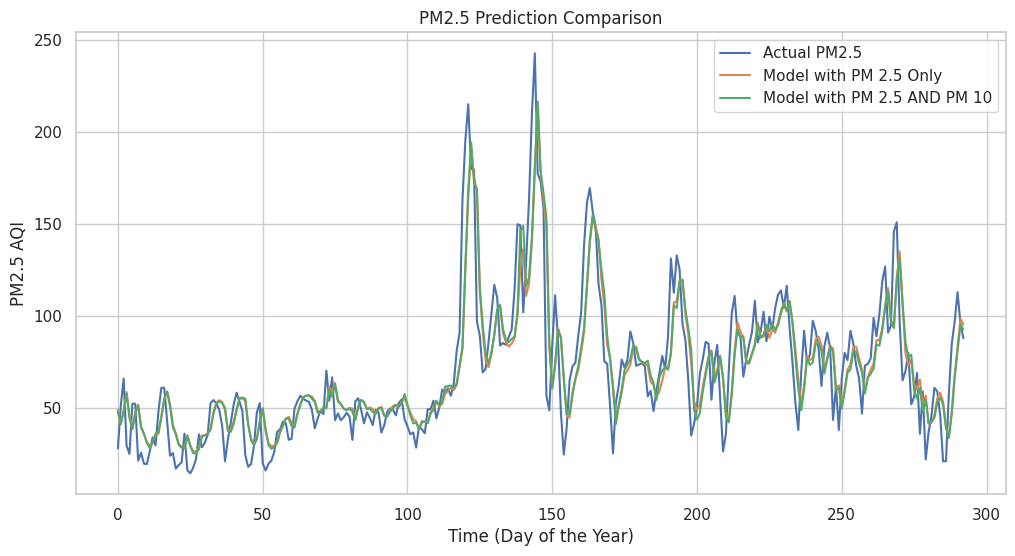

In [ ]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches

plt.plot(y_test_1_inv, label='Actual PM2.5')
plt.plot(pred1_inv, label='Model with PM 2.5 Only')
plt.plot(pred2_inv, label='Model with PM 2.5 AND PM 10')
plt.xlabel('Time (Day of the Year)')
plt.ylabel('PM2.5 AQI')
plt.title('PM2.5 Prediction Comparison')
plt.legend()
plt.show()

The MAE does not improve after adding PM 10. So, we shouldn't include it, as it most likely adds noise.

END of PM 10

LSTM Improvement with CO.

In [ ]:
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])
df = longest_run_df.sort_values('date_local')

# Select relevant columns
data_pm25 = df[['aqi_pm25']].values
data_pm25_co = df[['aqi_pm25', 'aqi_co']].values

<ipython-input-37-51567acd0df4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


In [ ]:
# Scale
scaler_1 = MinMaxScaler()
data_pm25_scaled = scaler_1.fit_transform(data_pm25)

scaler_2 = MinMaxScaler()
data_pm25_co_scaled = scaler_2.fit_transform(data_pm25_co)

In [ ]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # PM2.5 as target
    return np.array(X), np.array(y)

# 7-day sequence length
seq_len = 7

# For PM2.5 only
X_pm25, y_pm25 = create_sequences(data_pm25_scaled, seq_len)

# For PM2.5 + PM10
X_pm25_co, y_pm25_co = create_sequences(data_pm25_co_scaled, seq_len)

In [ ]:
train_size = int(0.8 * len(X_pm25))

# PM2.5 only
X_train_1, X_test_1 = X_pm25[:train_size], X_pm25[train_size:]
y_train_1, y_test_1 = y_pm25[:train_size], y_pm25[train_size:]

# PM2.5 + PM10
X_train_2, X_test_2 = X_pm25_co[:train_size], X_pm25_co[train_size:]
y_train_2, y_test_2 = y_pm25_co[:train_size], y_pm25_co[train_size:]

In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape=(seq_len, 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

model1.fit(X_train_1, y_train_1, epochs=8, batch_size=8, validation_data=(X_test_1, y_test_1))

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0390 - val_loss: 0.0118
Epoch 2/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0154 - val_loss: 0.0108
Epoch 3/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - val_loss: 0.0095
Epoch 4/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - val_loss: 0.0095
Epoch 5/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 6/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0078
Epoch 7/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 8/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0078


In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape=(seq_len, 2)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

model2.fit(X_train_2, y_train_2, epochs=8, batch_size=8, validation_data=(X_test_2, y_test_2))

Epoch 1/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0351 - val_loss: 0.0111
Epoch 2/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0149 - val_loss: 0.0096
Epoch 3/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0142 - val_loss: 0.0089
Epoch 4/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 5/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0087
Epoch 6/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0109 - val_loss: 0.0078
Epoch 7/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 8/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0100 - val_loss: 0.0078


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions
pred1 = model1.predict(X_test_1)
pred2 = model2.predict(X_test_2)

# Inverse transform
y_test_1_inv = scaler_1.inverse_transform(y_test_1.reshape(-1, 1))
pred1_inv = scaler_1.inverse_transform(pred1)

y_test_2_inv = scaler_2.inverse_transform(np.hstack((y_test_2.reshape(-1,1), np.zeros((len(y_test_2), 1)))))[:,0]
pred2_inv = scaler_2.inverse_transform(np.hstack((pred2, np.zeros((len(pred2), 1)))))[:,0]

# Calculate MAE
mae1 = mean_absolute_error(y_test_1_inv, pred1_inv)
mae2 = mean_absolute_error(y_test_2_inv, pred2_inv)

print(f"MAE (PM2.5 only): {mae1}")
print(f"MAE (PM2.5 + CO): {mae2}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE (PM2.5 only): 11.444245056266642
MAE (PM2.5 + CO): 11.414879085622635


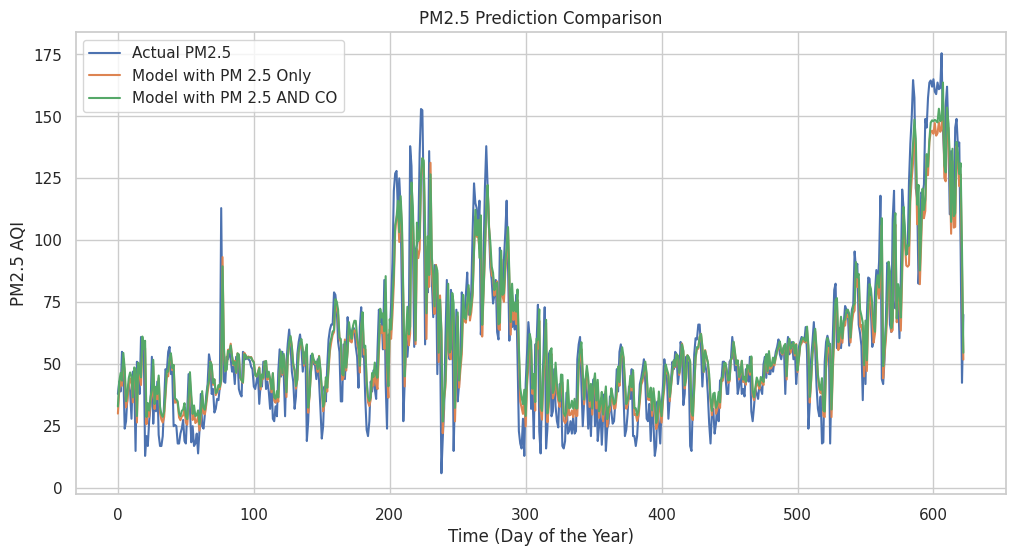

In [ ]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches

plt.plot(y_test_1_inv, label='Actual PM2.5')
plt.plot(pred1_inv, label='Model with PM 2.5 Only')
plt.plot(pred2_inv, label='Model with PM 2.5 AND CO')
plt.xlabel('Time (Day of the Year)')
plt.ylabel('PM2.5 AQI')
plt.title('PM2.5 Prediction Comparison')
plt.legend()
plt.show()

END of CO

LSTM Improvement with Ozone.

In [ ]:
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])
df = longest_run_df.sort_values('date_local')

# Select relevant columns
data_pm25 = df[['aqi_pm25']].values
data_pm25_other = df[['aqi_pm25', 'aqi_ozone']].values # CHANGE  HERE

# Scale
scaler_1 = MinMaxScaler()
data_pm25_scaled = scaler_1.fit_transform(data_pm25)

scaler_2 = MinMaxScaler()
data_pm25_other_scaled = scaler_2.fit_transform(data_pm25_other)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # PM2.5 as target
    return np.array(X), np.array(y)

# 7-day sequence length
seq_len = 7

# For PM2.5 only
X_pm25, y_pm25 = create_sequences(data_pm25_scaled, seq_len)

# For PM2.5 + PM10
X_pm25_other, y_pm25_other = create_sequences(data_pm25_other_scaled, seq_len)

train_size = int(0.8 * len(X_pm25))

# PM2.5 only
X_train_1, X_test_1 = X_pm25[:train_size], X_pm25[train_size:]
y_train_1, y_test_1 = y_pm25[:train_size], y_pm25[train_size:]

# PM2.5 + PM10
X_train_2, X_test_2 = X_pm25_other[:train_size], X_pm25_other[train_size:]
y_train_2, y_test_2 = y_pm25_other[:train_size], y_pm25_other[train_size:]


<ipython-input-59-ef9250344d0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape=(seq_len, 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

model1.fit(X_train_1, y_train_1, epochs=8, batch_size=8, validation_data=(X_test_1, y_test_1))


model2 = Sequential()
model2.add(LSTM(32, input_shape=(seq_len, 2)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

model2.fit(X_train_2, y_train_2, epochs=8, batch_size=8, validation_data=(X_test_2, y_test_2))

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions
pred1 = model1.predict(X_test_1)
pred2 = model2.predict(X_test_2)

# Inverse transform
y_test_1_inv = scaler_1.inverse_transform(y_test_1.reshape(-1, 1))
pred1_inv = scaler_1.inverse_transform(pred1)

y_test_2_inv = scaler_2.inverse_transform(np.hstack((y_test_2.reshape(-1,1), np.zeros((len(y_test_2), 1)))))[:,0]
pred2_inv = scaler_2.inverse_transform(np.hstack((pred2, np.zeros((len(pred2), 1)))))[:,0]

# Calculate MAE
mae1 = mean_absolute_error(y_test_1_inv, pred1_inv)
mae2 = mean_absolute_error(y_test_2_inv, pred2_inv)

print(f"MAE (PM2.5 only): {mae1}")
print(f"MAE (PM2.5 + Ozone): {mae2}") # CHANGE HERE

plt.figure(figsize=(12, 6))

plt.plot(y_test_1_inv, label='Actual PM2.5')
plt.plot(pred1_inv, label='Model with PM 2.5 Only')
plt.plot(pred2_inv, label='Model with PM 2.5 AND Ozone') # CHANGE HERE
plt.xlabel('Time (Day of the Year)')
plt.ylabel('PM2.5 AQI')
plt.title('PM2.5 Prediction Comparison')
plt.legend()
plt.show()



Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LookupError: gradient registry has no entry for: shap_DivNoNan

END of Ozone

In [ ]:
# merge the pm25 and pm10 data
fresno_pm25_ozone = pd.merge(fresno_pm25, fresno_ozone, on=["date_local", "site_number"], how="left", suffixes=("_pm25", "_ozone"))

In [ ]:
# find the longest consecutive sequence of rows
df_sorted = fresno_pm25_ozone.sort_values(by=['site_number', 'date_local']).reset_index(drop=True)

df_sorted['valid'] = df_sorted[['aqi_pm25', 'aqi_ozone']].notna().all(axis=1)

df_sorted['group'] = (
    (df_sorted['site_number'] != df_sorted['site_number'].shift()) |
    (df_sorted['valid'] != df_sorted['valid'].shift())
).cumsum()

valid_groups = df_sorted[df_sorted['valid']].groupby(['site_number', 'group'])

group_sizes = valid_groups.size()

max_site, max_group = group_sizes.idxmax()   # returns (site_number, group)
max_length = group_sizes.max()

# extract the actual rows
longest_run_df = df_sorted[
    (df_sorted['site_number'] == max_site) &
    (df_sorted['group'] == max_group)
]

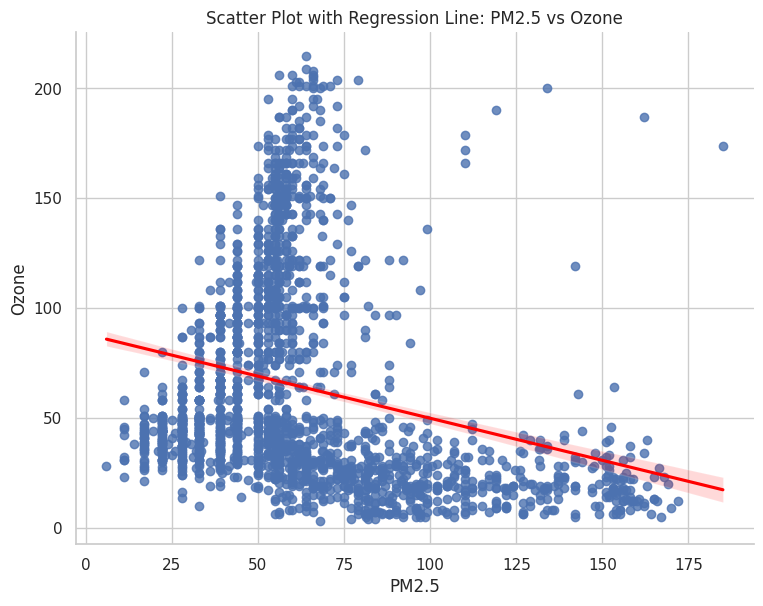

In [ ]:
# Assuming longest_run_df is your DataFrame
sns.set(style="whitegrid")

# lmplot works on dataframes using string column names
sns.lmplot(
    x="aqi_pm25",
    y="aqi_ozone",
    data=longest_run_df,
    height=6,
    aspect=1.3,
    line_kws={'color': 'red'}
)

plt.xlabel('PM2.5')
plt.ylabel('Ozone')
plt.title('Scatter Plot with Regression Line: PM2.5 vs Ozone')
plt.show()

<ipython-input-131-fde70856e367>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


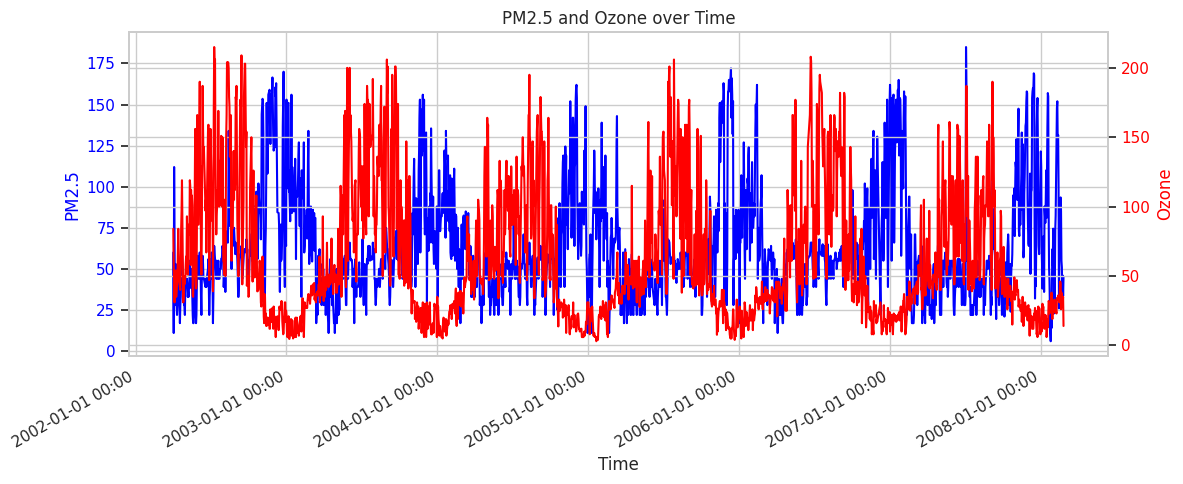

In [ ]:
# Convert date_local to datetime if it isn't already
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot PM2.5 on ax1
ax1.plot(longest_run_df["date_local"], longest_run_df["aqi_pm25"], color='blue', label='PM2.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # Auto-rotate and align date labels

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(longest_run_df["date_local"], longest_run_df["aqi_ozone"], color='red', label='Ozone')
ax2.set_ylabel('Ozone', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('PM2.5 and Ozone over Time')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# get the individual series
pm25_series = longest_run_df["aqi_pm25"]
ozone_series = longest_run_df["aqi_ozone"]

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, ozone_series)


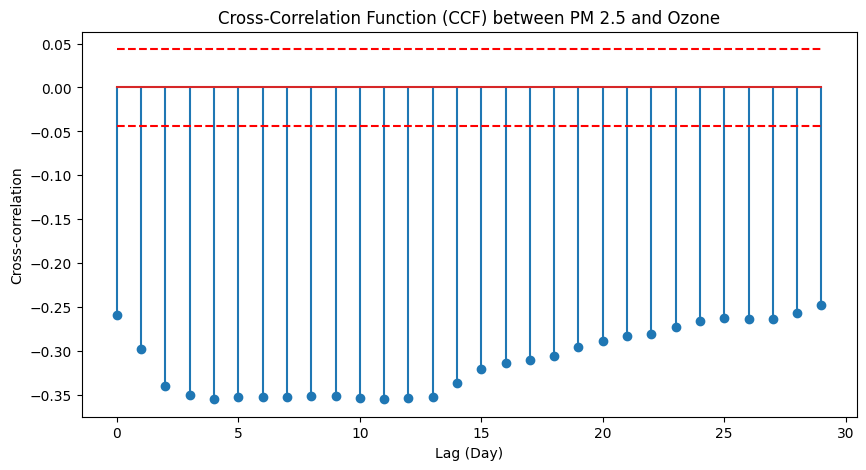

In [ ]:
# Plot the CCF
N = len(pm25_series)  # Number of observations
conf_bound = 1.96 / np.sqrt(N)

# Plot the CCF
lags = np.arange(30)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values[:30])
plt.hlines([conf_bound, -conf_bound], xmin=0, xmax=max(lags), linestyles='dashed', colors='red')
plt.title('Cross-Correlation Function (CCF) between PM 2.5 and Ozone')
plt.xlabel('Lag (Day)')
plt.ylabel('Cross-correlation')
plt.show()

Interpretation: this shows that PM 2.5 and Ozone are very weakly negatively correlated, since the magnitude is -0.25 to -0.35 out of -1. Thus, Ozone is probably not useful in estimating PM 2.5.

In [ ]:
# merge the pm25 and pm10 data
fresno_pm25_no2 = pd.merge(fresno_pm25, fresno_no2, on=["date_local", "site_number"], how="left", suffixes=("_pm25", "_no2"))


In [ ]:
# find the longest consecutive sequence of rows
df_sorted = fresno_pm25_no2.sort_values(by=['site_number', 'date_local']).reset_index(drop=True)

df_sorted['valid'] = df_sorted[['aqi_pm25', 'aqi_no2']].notna().all(axis=1)

df_sorted['group'] = (
    (df_sorted['site_number'] != df_sorted['site_number'].shift()) |
    (df_sorted['valid'] != df_sorted['valid'].shift())
).cumsum()

valid_groups = df_sorted[df_sorted['valid']].groupby(['site_number', 'group'])

group_sizes = valid_groups.size()

max_site, max_group = group_sizes.idxmax()   # returns (site_number, group)
max_length = group_sizes.max()

# extract the actual rows
longest_run_df = df_sorted[
    (df_sorted['site_number'] == max_site) &
    (df_sorted['group'] == max_group)
]

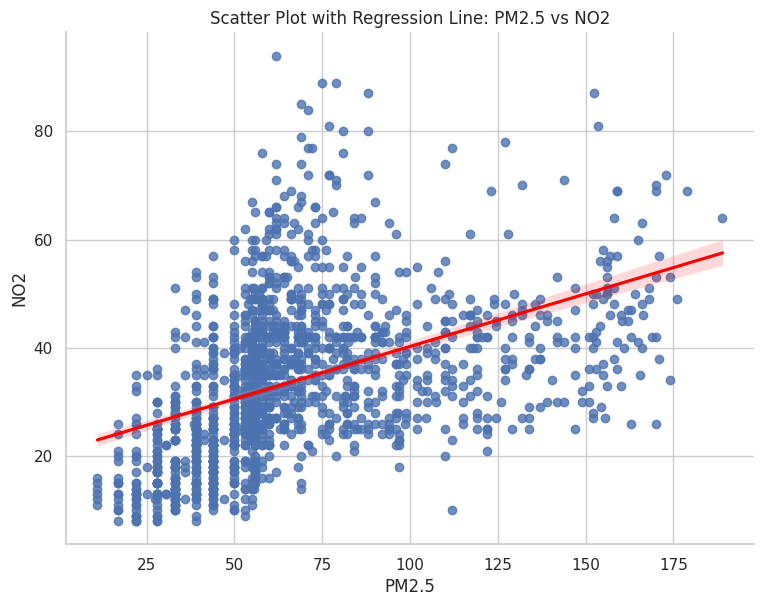

In [ ]:
# Assuming longest_run_df is your DataFrame
sns.set(style="whitegrid")

# lmplot works on dataframes using string column names
sns.lmplot(
    x="aqi_pm25",
    y="aqi_no2",
    data=longest_run_df,
    height=6,
    aspect=1.3,
    line_kws={'color': 'red'}
)

plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Scatter Plot with Regression Line: PM2.5 vs NO2')
plt.show()

<ipython-input-135-d49cdae7fbbe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


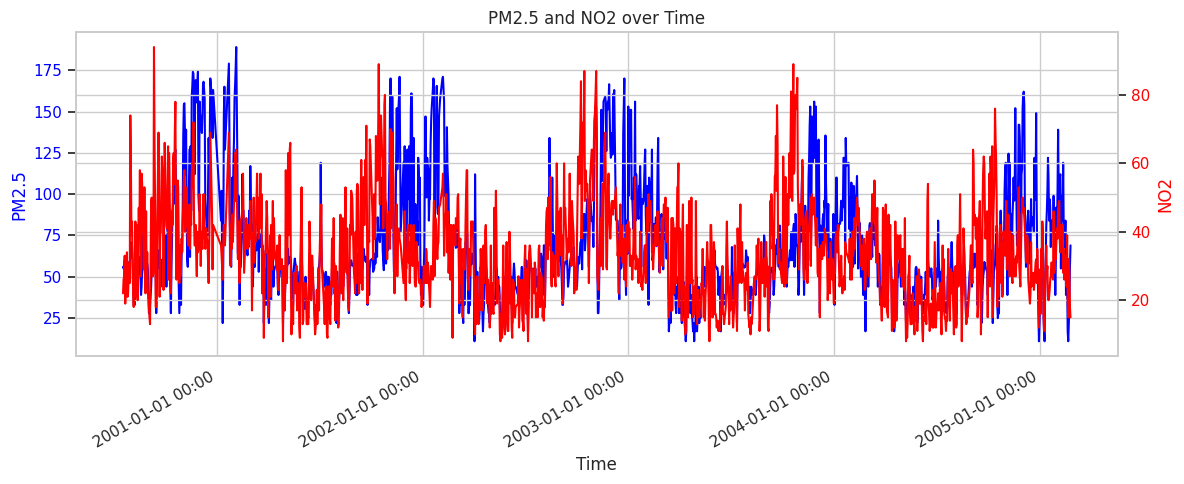

In [ ]:
# Convert date_local to datetime if it isn't already
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot PM2.5 on ax1
ax1.plot(longest_run_df["date_local"], longest_run_df["aqi_pm25"], color='blue', label='PM2.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # Auto-rotate and align date labels

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(longest_run_df["date_local"], longest_run_df["aqi_no2"], color='red', label='NO2')
ax2.set_ylabel('NO2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('PM2.5 and NO2 over Time')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# get the individual series
pm25_series = longest_run_df["aqi_pm25"]
no2_series = longest_run_df["aqi_no2"]

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, no2_series)


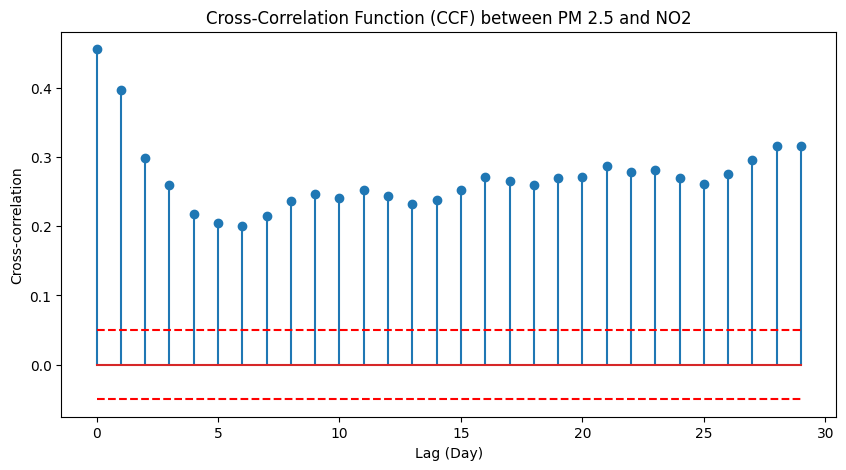

In [ ]:
# Plot the CCF
N = len(pm25_series)  # Number of observations
conf_bound = 1.96 / np.sqrt(N)

# Plot the CCF
lags = np.arange(30)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values[:30])
plt.hlines([conf_bound, -conf_bound], xmin=0, xmax=max(lags), linestyles='dashed', colors='red')
plt.title('Cross-Correlation Function (CCF) between PM 2.5 and NO2')
plt.xlabel('Lag (Day)')
plt.ylabel('Cross-correlation')
plt.show()

0.46 / 1 is not really a strong correlation, so NO2 is probably does not contribute to PM 2.5

In [ ]:
# merge the pm25 and pm10 data
fresno_pm25_co = pd.merge(fresno_pm25, fresno_co, on=["date_local", "site_number"], how="left", suffixes=("_pm25", "_co"))


In [ ]:
# find the longest consecutive sequence of rows
df_sorted = fresno_pm25_co.sort_values(by=['site_number', 'date_local']).reset_index(drop=True)

df_sorted['valid'] = df_sorted[['aqi_pm25', 'aqi_co']].notna().all(axis=1)

df_sorted['group'] = (
    (df_sorted['site_number'] != df_sorted['site_number'].shift()) |
    (df_sorted['valid'] != df_sorted['valid'].shift())
).cumsum()

valid_groups = df_sorted[df_sorted['valid']].groupby(['site_number', 'group'])

group_sizes = valid_groups.size()

max_site, max_group = group_sizes.idxmax()   # returns (site_number, group)
max_length = group_sizes.max()

# extract the actual rows
longest_run_df = df_sorted[
    (df_sorted['site_number'] == max_site) &
    (df_sorted['group'] == max_group)
]

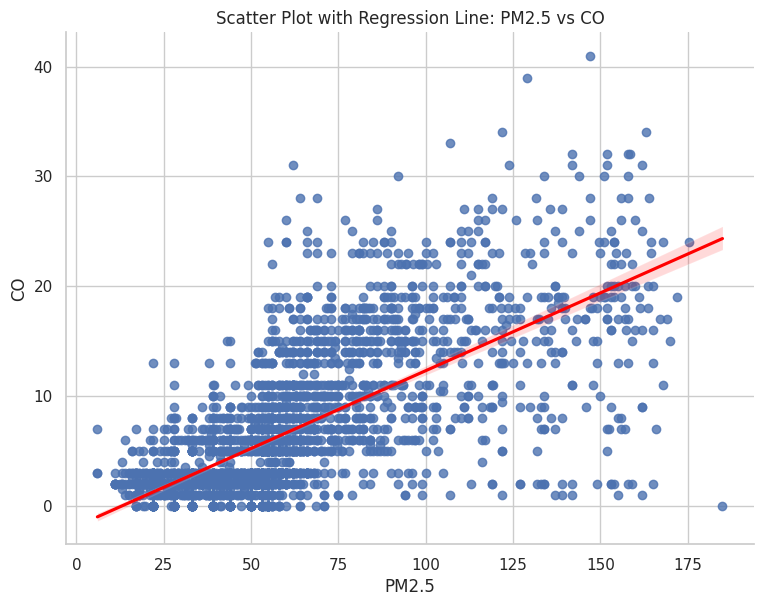

In [ ]:
# Assuming longest_run_df is your DataFrame
sns.set(style="whitegrid")

# lmplot works on dataframes using string column names
sns.lmplot(
    x="aqi_pm25",
    y="aqi_co",
    data=longest_run_df,
    height=6,
    aspect=1.3,
    line_kws={'color': 'red'}
)

plt.xlabel('PM2.5')
plt.ylabel('CO')
plt.title('Scatter Plot with Regression Line: PM2.5 vs CO')
plt.show()

<ipython-input-123-877a0777fbe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


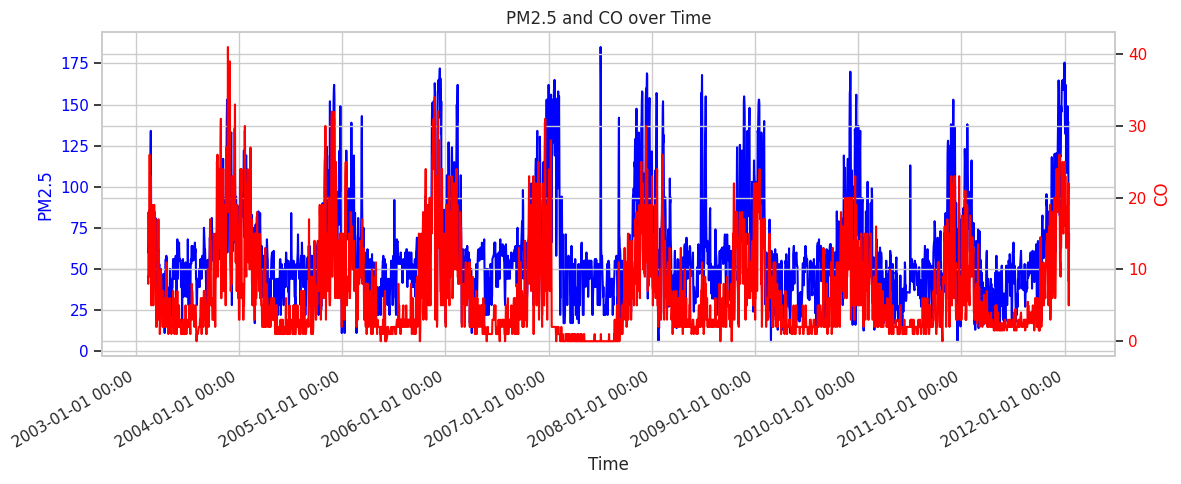

In [ ]:
# Convert date_local to datetime if it isn't already
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot PM2.5 on ax1
ax1.plot(longest_run_df["date_local"], longest_run_df["aqi_pm25"], color='blue', label='PM2.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # Auto-rotate and align date labels

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(longest_run_df["date_local"], longest_run_df["aqi_co"], color='red', label='CO')
ax2.set_ylabel('CO', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('PM2.5 and CO over Time')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# get the individual series
pm25_series = longest_run_df["aqi_pm25"]
co_series = longest_run_df["aqi_co"]

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, co_series)


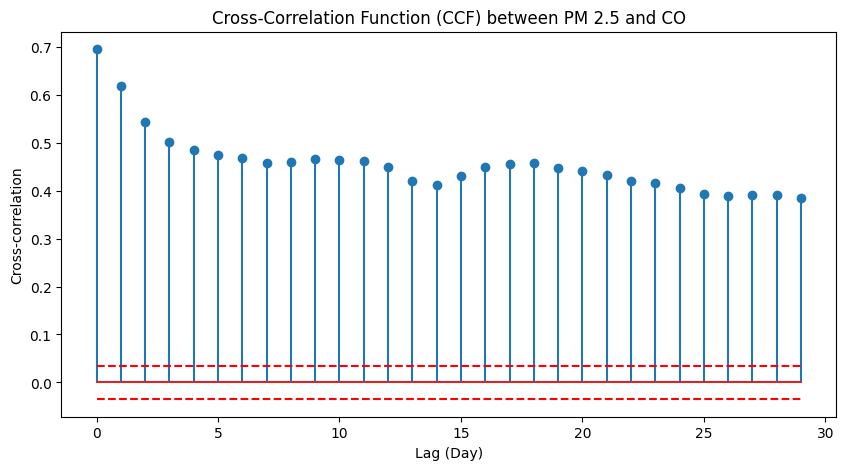

In [ ]:
# Plot the CCF
N = len(pm25_series)  # Number of observations
conf_bound = 1.96 / np.sqrt(N)

# Plot the CCF
lags = np.arange(30)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values[:30])
plt.hlines([conf_bound, -conf_bound], xmin=0, xmax=max(lags), linestyles='dashed', colors='red')
plt.title('Cross-Correlation Function (CCF) between PM 2.5 and CO')
plt.xlabel('Lag (Day)')
plt.ylabel('Cross-correlation')
plt.show()

This shows that Carbon Monoxide (CO) has a very strong correlation with PM 2.5 at lag = 0. Thus, we should probably include it in the LSTM (or other) model for predicting PM 2.5. The chemical and environmental research supports this correlation. Both CO and PM2.5 are emitted by the same sources: Combustion of fossil fuels — like cars, trucks, factories, and power plants. Biomass burning — like wildfires, wood stoves, and agricultural burning. Industrial processes.

In [ ]:
# merge the pm25 and pm10 data
fresno_pm25_so2 = pd.merge(fresno_pm25, fresno_so2, on=["date_local", "site_number"], how="left", suffixes=("_pm25", "_so2"))


In [ ]:
# find the longest consecutive sequence of rows
df_sorted = fresno_pm25_so2.sort_values(by=['site_number', 'date_local']).reset_index(drop=True)

df_sorted['valid'] = df_sorted[['aqi_pm25', 'aqi_so2']].notna().all(axis=1)

df_sorted['group'] = (
    (df_sorted['site_number'] != df_sorted['site_number'].shift()) |
    (df_sorted['valid'] != df_sorted['valid'].shift())
).cumsum()

valid_groups = df_sorted[df_sorted['valid']].groupby(['site_number', 'group'])

group_sizes = valid_groups.size()

max_site, max_group = group_sizes.idxmax()   # returns (site_number, group)
max_length = group_sizes.max()

# extract the actual rows
longest_run_df = df_sorted[
    (df_sorted['site_number'] == max_site) &
    (df_sorted['group'] == max_group)
]

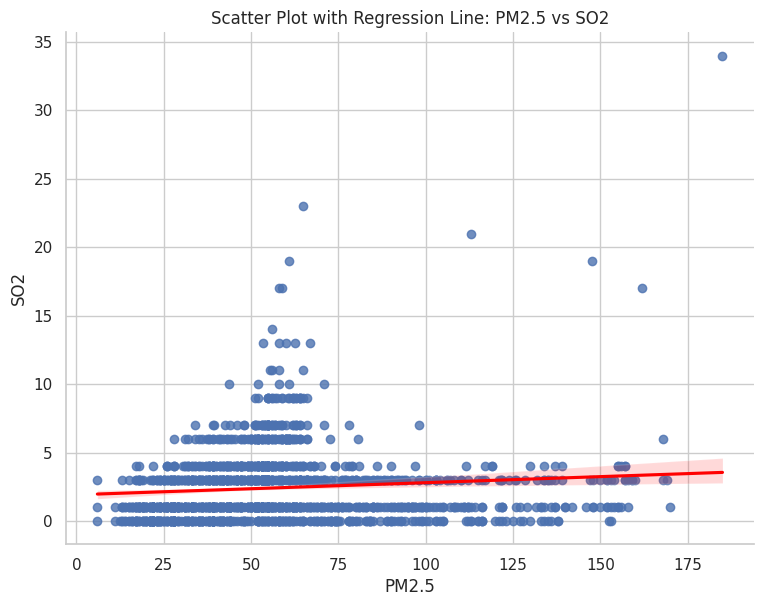

In [ ]:
# Assuming longest_run_df is your DataFrame
sns.set(style="whitegrid")

# lmplot works on dataframes using string column names
sns.lmplot(
    x="aqi_pm25",
    y="aqi_so2",
    data=longest_run_df,
    height=6,
    aspect=1.3,
    line_kws={'color': 'red'}
)

plt.xlabel('PM2.5')
plt.ylabel('SO2')
plt.title('Scatter Plot with Regression Line: PM2.5 vs SO2')
plt.show()

<ipython-input-139-5108d90ef3dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])


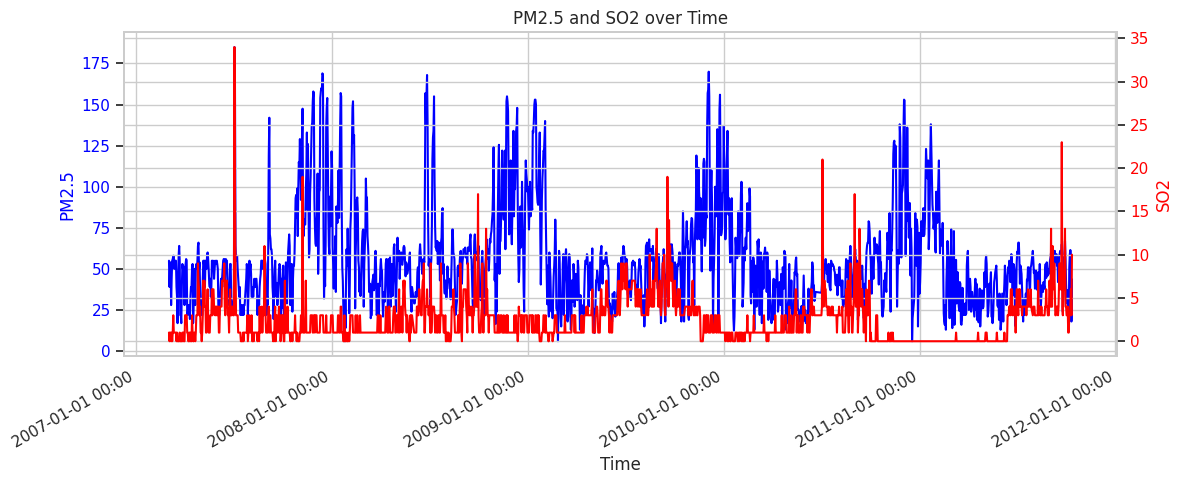

In [ ]:
# Convert date_local to datetime if it isn't already
longest_run_df["date_local"] = pd.to_datetime(longest_run_df["date_local"])

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot PM2.5 on ax1
ax1.plot(longest_run_df["date_local"], longest_run_df["aqi_pm25"], color='blue', label='PM2.5')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # Auto-rotate and align date labels

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(longest_run_df["date_local"], longest_run_df["aqi_so2"], color='red', label='SO2')
ax2.set_ylabel('SO2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('PM2.5 and SO2 over Time')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# get the individual series
pm25_series = longest_run_df["aqi_pm25"]
so2_series = longest_run_df["aqi_so2"]

In [ ]:
# apply CCF
ccf_values = ccf(pm25_series, so2_series)


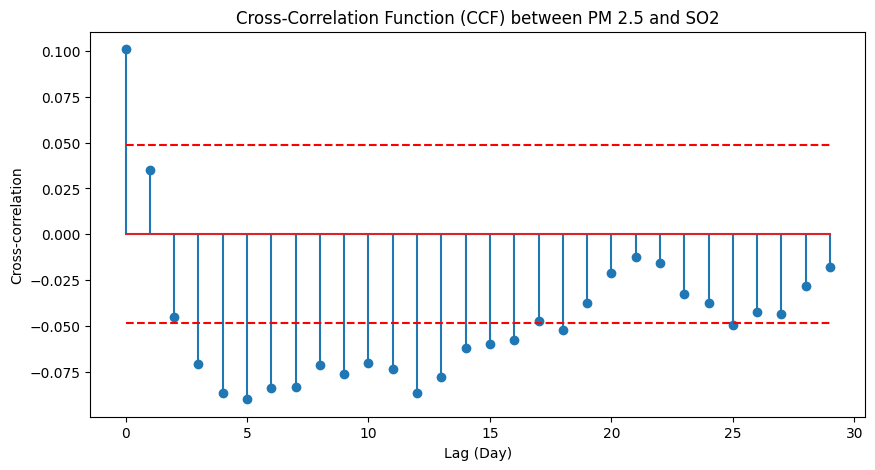

In [ ]:
# Plot the CCF
N = len(pm25_series)  # Number of observations
conf_bound = 1.96 / np.sqrt(N)

# Plot the CCF
lags = np.arange(30)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values[:30])
plt.hlines([conf_bound, -conf_bound], xmin=0, xmax=max(lags), linestyles='dashed', colors='red')
plt.title('Cross-Correlation Function (CCF) between PM 2.5 and SO2')
plt.xlabel('Lag (Day)')
plt.ylabel('Cross-correlation')
plt.show()

No correlation at all for SO2 and PM 2.5. Thus, we should not include it in ML models.

Step 5: Before applying Granger Causality, we need to make sure that PM 2.5 is Stationary

Step 5.1: Test for Stationarity by Using Rolling Mean and STD

<ipython-input-26-08eab5501583>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df['date_local'] = pd.to_datetime(longest_run_df['date_local'])


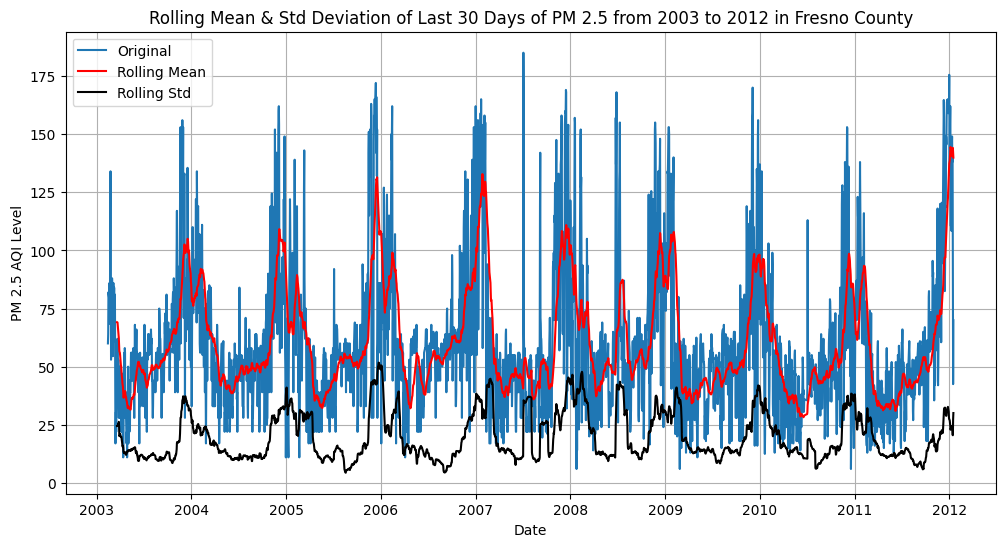

In [ ]:
# Assuming 'date' is the column with timestamps
longest_run_df['date_local'] = pd.to_datetime(longest_run_df['date_local'])
longest_run_df.set_index('date_local', inplace=True)

pm25 = longest_run_df["aqi_pm25"].dropna()
rolling_mean = pm25.rolling(window=30).mean()
rolling_std = pm25.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(pm25, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')

plt.legend()
plt.title('Rolling Mean & Std Deviation of Last 30 Days of PM 2.5 from 2003 to 2012 in Fresno County')
plt.ylabel("PM 2.5 AQI Level")
plt.xlabel("Date")   # Now the x-axis will display dates
plt.grid(True)
plt.show()

Because the mean and std does not remain relatively flat — the PM 2.5 data is not stationarity.



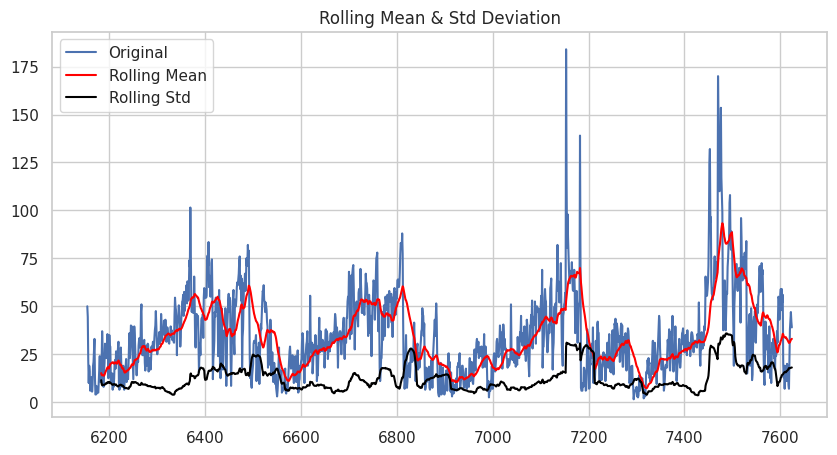

In [ ]:
pm10 = longest_run_df["aqi_pm10"].dropna()
rolling_mean = pm10.rolling(window=30).mean()
rolling_std = pm10.rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(pm10, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Rolling Mean & Std Deviation')
plt.show()

Because the mean and std does not remain relatively flat — the PM 10 data is not stationarity.


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(pm25)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -5.271418154965994
p-value: 6.273647744684418e-06


Step 5.2: Apply Differencing to Make the Data Stationary. Granger Causality Expects Both Time Series Data to Be Stationary.

In [ ]:
pm25_diff = pm25.diff()
pm10_diff = pm10.diff()

Step 5.3: Test Stationarity on the Differenced Data

In [ ]:
longest_run_df["aqi_pm25_diff"] = longest_run_df["aqi_pm25"].diff()

<ipython-input-28-6d19cecba66a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_run_df["aqi_pm25_diff"] = longest_run_df["aqi_pm25"].diff()


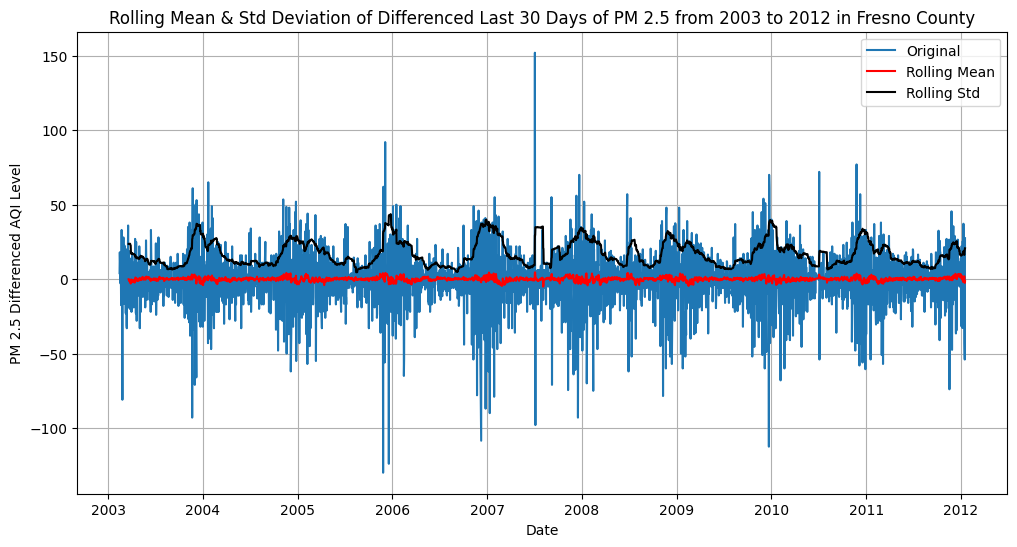

In [ ]:
pm25 = longest_run_df["aqi_pm25_diff"].dropna()
rolling_mean = pm25.rolling(window=30).mean()
rolling_std = pm25.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(pm25, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')

plt.legend()
plt.title('Rolling Mean & Std Deviation of Differenced Last 30 Days of PM 2.5 from 2003 to 2012 in Fresno County')
plt.ylabel("PM 2.5 Differenced AQI Level")
plt.xlabel("Date")
plt.grid(True)
plt.show()

The rolling mean becomes flat, the std becomes much flatter, but still there is seasonality. This series is most likely stationary enough now.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(pm25_diff.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -15.49319711043143
p-value: 2.469573751160733e-28


The Adfuller Test states that it is stationary

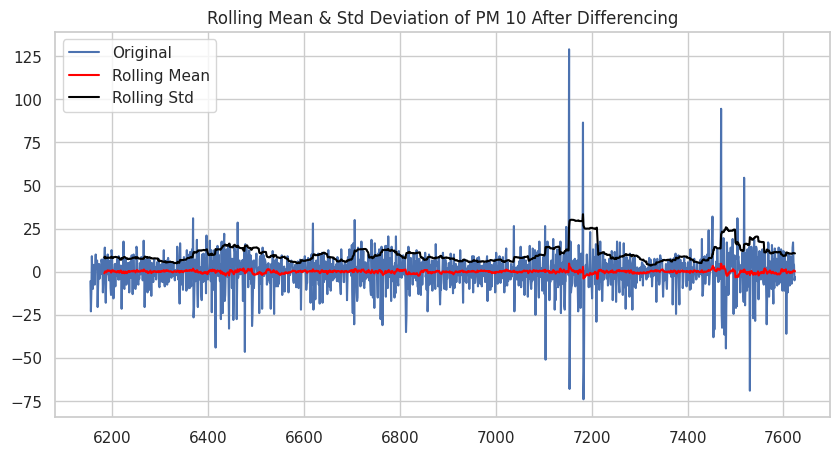

In [ ]:
rolling_mean = pm10_diff.rolling(window=30).mean()
rolling_std = pm10_diff.rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(pm10_diff, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Rolling Mean & Std Deviation of PM 10 After Differencing')
plt.show()

The PM 10 series becomes completely flat both in rolling mean and rolling std. Thus, it is stationary now.

The data is stationary after the differencing.



Testing Seasonally Differencing

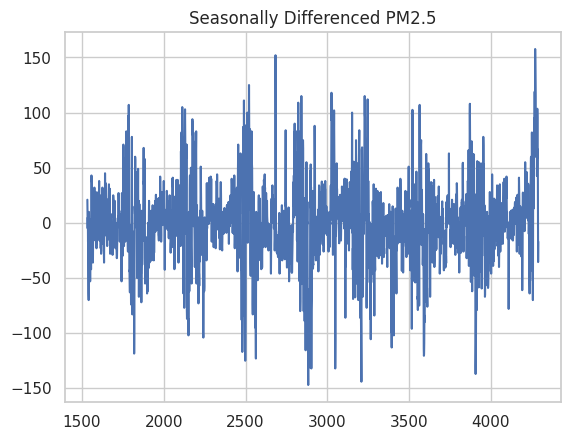

In [ ]:
# Seasonal differencing for PM2.5 with yearly seasonality (assuming 365 days)
seasonal_diff_pm25 = pm25 - pm25.shift(365)

# Drop NaN values generated by shifting
seasonal_diff_pm25 = seasonal_diff_pm25.dropna()

# Visualize the differenced data
plt.plot(seasonal_diff_pm25)
plt.title('Seasonally Differenced PM2.5')
plt.show()

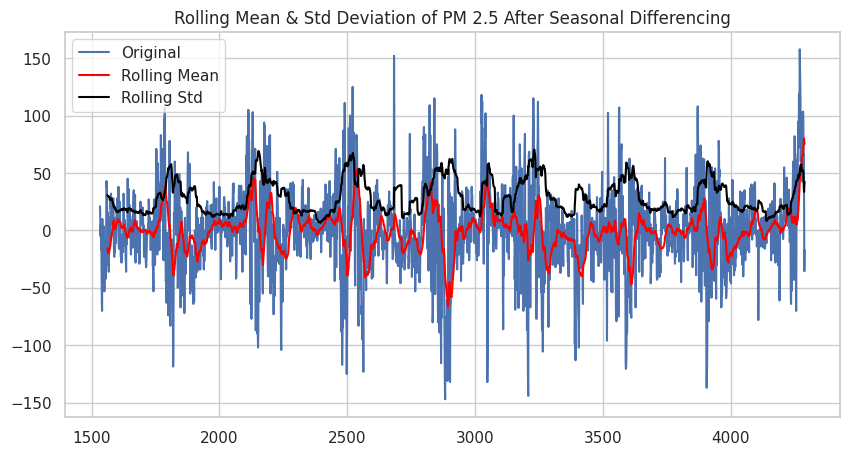

In [ ]:
rolling_mean = seasonal_diff_pm25.rolling(window=30).mean()
rolling_std = seasonal_diff_pm25.rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(seasonal_diff_pm25, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Rolling Mean & Std Deviation of PM 2.5 After Seasonal Differencing')
plt.show()

Seasonal differencing is not making this series stationary at all. The data is still non-stationary. Thus, it is better to choose the normally differenced data.

END of Seasonally Differencing

Step 4: We know that correlation does not necessarily mean causation. Let's check causation between PM 2.5 and other pollutants by applying Granger Causality. By doing this, we can answer, "Do past values of one series (PM 10 or CO) predict the other (PM 2.5)?" In CCF, we saw that PM 10 and CO have very strong correlations with PM 2.5, but do they really cause PM 2.5?

In [ ]:
pm25_diff = pm25.diff()
pm10_diff = pm10.diff()

,aqi_pm10
6154,NaN
6155,-5.5
6156,-23.0
6157,-11.5
6158,9.0
...,...
7620,17.0
7621,5.0
7622,4.0
7623,-5.0
